In [1]:
import pickle
import pandas as pd
import os
import glob
from IPython.display import display
import matplotlib.pyplot as plt

Reading the files with Market Iterations: These are for multiple auctions in one run


In [2]:
def read_pickle_file(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

In [ ]:
# Directing to the path where the results are stored adn read all the pickle files (Market 0 to end market), extracting the market times
# and storing the data in a list of dictionaries. The list is then converted to a DataFrame for easier visualization.
current_dir = os.getcwd()
parent_folder = os.path.abspath(os.path.join(current_dir, ".."))
folder_path = os.path.join(
    parent_folder,
    "results",
    "modified_bidbudget_toulouse_case3_withC_cap5_withReturn_3_highcap_fisher_b-50.0_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250204_111131",
    "results"
)


fisher_files = sorted(glob.glob(os.path.join(folder_path, "fisher_data_*.pkl")))
fisher_after_files = sorted(glob.glob(os.path.join(folder_path, "fisher_data_after_*.pkl")))

# Extract the market auction time from filenames
def extract_time(filename):
    return int(filename.split("_")[-1].split(".")[0])  # Extracts the number from fisher_data_X.pkl


fisher_data_list = []
after_fisher_data_list = []

# Iterate over paired files
for fisher_file, fisher_after_file in zip(fisher_files, fisher_after_files):
    fisher_data = read_pickle_file(fisher_file)
    end_of_market_data = read_pickle_file(fisher_after_file)

    if fisher_data is None or end_of_market_data is None:
        continue  # Skip if reading failed

    market_time = extract_time(fisher_file)

    # Extract necessary data from Fisher Market (Before Transactions)
    prices = fisher_data["prices"]
    goods_list = fisher_data["goods_list"]

    # Extract necessary data from End of Market (After Transactions)
    market_data = end_of_market_data["market_data"]
    agents_data = end_of_market_data["agents_data"]

    # Extract market-level data
    end_capacities = market_data["capacity"]
    initial_capacities = market_data["original_capacity"]
    end_prices = market_data["prices"]  # Prices after transactions (if they change)

    print(f"\n🔎 Processing Market Time: {market_time}")
    print(f"  📌 Found {len(fisher_data['desired_goods'])} agents")

    for agent, agent_data in fisher_data["desired_goods"].items():
        desired_indx = agent_data['desired_transit_edges_idx'][0]  # Directly access

        try:
            # Data before transactions (Fisher Market)
            fisher_data_list.append({
                "Market_Time": market_time,
                "Agent": agent,
                "Edge_Index": desired_indx,
                "Price": prices[desired_indx],  # Price before transaction
                "Initial_Capacity": initial_capacities[desired_indx],  # Starting capacity
                "Good": goods_list[desired_indx][1],
                "Data_Type": "Fisher"
            })

            # Extract agent-specific information after the market transaction
            agent_final_allocation = agents_data[agent].get("final_allocation", {})
            agent_payment = agents_data[agent].get("payment", 0)
            agent_valuation = agents_data[agent].get("valuation", {})

            # Data after transactions (After Fisher Market)
            after_fisher_data_list.append({
                "Market_Time": market_time,
                "Agent": agent,
                "Edge_Index": desired_indx,
                "Price": end_prices[desired_indx],  # Final price after auction
                "End_Capacity": end_capacities[desired_indx],  # Capacity after auction
                "Good": goods_list[desired_indx][1],
                "Final_Goods_allocated": agents_data[agent]["agent_goods_list"],  # Final goods allocated
                "Final_goods_vector": agent_final_allocation,
                "Payment": agent_payment,
                "Data_Type": "After_Fisher"
            })
        except KeyError as e:
            print(f"    ❌ Skipping {agent}: Key {e} not found in dataset!")

# Create DataFrames
df_fisher = pd.DataFrame(fisher_data_list)
df_after_fisher = pd.DataFrame(after_fisher_data_list)

# ## uncomment below if you want to see the entire dataframe
# # pd.set_option('display.max_rows', None)  # Show all rows
# # pd.set_option('display.max_columns', None)  # Show all columns
# # pd.set_option('display.width', 1000)  # Adjust width to prevent line breaks
# # pd.set_option('display.max_colwidth', None)  # Prevent column truncation
# # display(df)



In [ ]:
# Display high-level structure of data
print("📊 Summary of Fisher Market Data Structure:")
print("High-level data from End of Market:", list(end_of_market_data.keys()))
print("High-level data from Fisher Market:", list(fisher_data.keys()))

# DataFrame summaries
print("\n🗂 Fisher Market Data Overview:")
display(df_fisher.info())
display(df_fisher.sample(10))

print("\n🗂 After Fisher Market Data Overview:")
display(df_after_fisher.info())
display(df_after_fisher.sample(10))


In [ ]:
# Ensure Market_Time is an integer for proper sorting
df_fisher['Market_Time'] = df_fisher['Market_Time'].astype(int)

# Split "Good" into "Sector" and "Request_Time"
df_fisher[['Sector', 'Request_Time']] = df_fisher['Good'].str.split('_', expand=True)

# Convert Request_Time to integer
df_fisher['Request_Time'] = df_fisher['Request_Time'].astype(int)

# Group by Sector, Request_Time, and Market_Time while counting the number of agents
sector_request_counts = (
    df_fisher.groupby(['Sector', 'Request_Time', 'Market_Time'])['Agent']
    .count()
    .reset_index()
    .rename(columns={'Agent': 'Num_Agents'})
)

# Sort the DataFrame by Market_Time (ascending), Request_Time, and Sector (both descending)
sector_request_counts_sorted = sector_request_counts.sort_values(
    by=["Market_Time", "Request_Time", "Sector"], ascending=[True, True, True]
)

# Display DataFrame
pd.set_option('display.max_rows', None)
display(sector_request_counts_sorted)



## Plot Performance Data

In [3]:
current_dir = os.getcwd()
parent_folder = os.path.abspath(os.path.join(current_dir, ".."))

file_list = ["toulouse_case_cap13_updated_fisher_b-50.0_agents10_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_154841",
             "toulouse_case_cap13_updated_fisher_b-50.0_agents40_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_154851",
             "toulouse_case_cap13_updated_fisher_b-50.0_agents80_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_154921",
             "toulouse_case_cap13_updated_fisher_b-50.0_agents120_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_155023",
             "toulouse_case_cap13_updated_fisher_b-50.0_agents160_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_155212",
             "toulouse_case_cap13_updated_fisher_b-50.0_agents177_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_155448",
             "toulouse_case_cap10_updated_fisher_b-50.0_agents10_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_161400",
             "toulouse_case_cap10_updated_fisher_b-50.0_agents40_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_161410",
             "toulouse_case_cap10_updated_fisher_b-50.0_agents80_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_161440",
             "toulouse_case_cap10_updated_fisher_b-50.0_agents120_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_161756",
             "toulouse_case_cap10_updated_fisher_b-50.0_agents160_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_162731",
             "toulouse_case_cap10_updated_fisher_b-50.0_agents177_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_164125",
             "toulouse_case_cap7_updated_fisher_b-50.0_agents10_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_170323",
             "toulouse_case_cap7_updated_fisher_b-50.0_agents40_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_170335",
             "toulouse_case_cap7_updated_fisher_b-50.0_agents80_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_170543",
             "toulouse_case_cap7_updated_fisher_b-50.0_agents120_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_171238",
            "toulouse_case_cap7_updated_fisher_b-50.0_agents160_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_172828",
            "toulouse_case_cap7_updated_fisher_b-50.0_agents177_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_210343",
            "toulouse_case_cap4_updated_fisher_b-50.0_agents10_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_183540",
            "toulouse_case_cap4_updated_fisher_b-50.0_agents40_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_183549",
            "toulouse_case_cap4_updated_fisher_b-50.0_agents80_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_185000",
            "toulouse_case_cap4_updated_fisher_b-50.0_agents120_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_191252",
            "toulouse_case_cap4_updated_fisher_b-50.0_agents160_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_213948",
            "toulouse_case_cap4_updated_fisher_b-50.0_agents177_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250225_202205"

             

]


df_list = []

for file in file_list:
    folder_path = os.path.join(parent_folder, "results", file, "results")
    csv_file_path = os.path.join(folder_path, 'market_performance_table.csv')
    
    try:
        df_csv = pd.read_csv(csv_file_path)
        df_csv["File"] = file  # column to track file origin
        capacity = int(file.split('_cap')[1].split('_')[0])
        df_csv["Capacity"] = capacity
        df_list.append(df_csv)
    except FileNotFoundError:
        print(f"File not found: {csv_file_path}")
    except pd.errors.EmptyDataError:
        print(f"File is empty: {csv_file_path}")

# Concatenate all DataFrames
pd.set_option('display.max_rows', None) 
if df_list:
    combined_df = pd.concat(df_list, ignore_index=True)
    # display(combined_df.head())
    display(combined_df)
else:
    print("No data was loaded.")

 

,Market_Auction_Start_Time,Number_Interations,Number_Agents,Num_Goods,Number_Contested_Routes,Run_Time,File,Capacity
0,0,7,10,992,0,3.94628,toulouse_case_cap13_updated_fisher_b-50.0_agen...,13
1,0,8,40,2681,0,16.77201,toulouse_case_cap13_updated_fisher_b-50.0_agen...,13
2,0,8,80,4593,0,34.92410,toulouse_case_cap13_updated_fisher_b-50.0_agen...,13
3,0,8,120,6857,0,59.26015,toulouse_case_cap13_updated_fisher_b-50.0_agen...,13
4,0,8,160,8474,0,83.31170,toulouse_case_cap13_updated_fisher_b-50.0_agen...,13
5,0,97,176,8841,3,1074.76626,toulouse_case_cap13_updated_fisher_b-50.0_agen...,13
6,0,7,10,992,0,4.04946,toulouse_case_cap10_updated_fisher_b-50.0_agen...,10
7,0,8,40,2681,4,17.03125,toulouse_case_cap10_updated_fisher_b-50.0_agen...,10
8,0,39,80,4593,7,168.02080,toulouse_case_cap10_updated_fisher_b-50.0_agen...,10
9,0,70,120,6857,17,525.10485,toulouse_case_cap10_updated_fisher_b-50.0_agen...,10


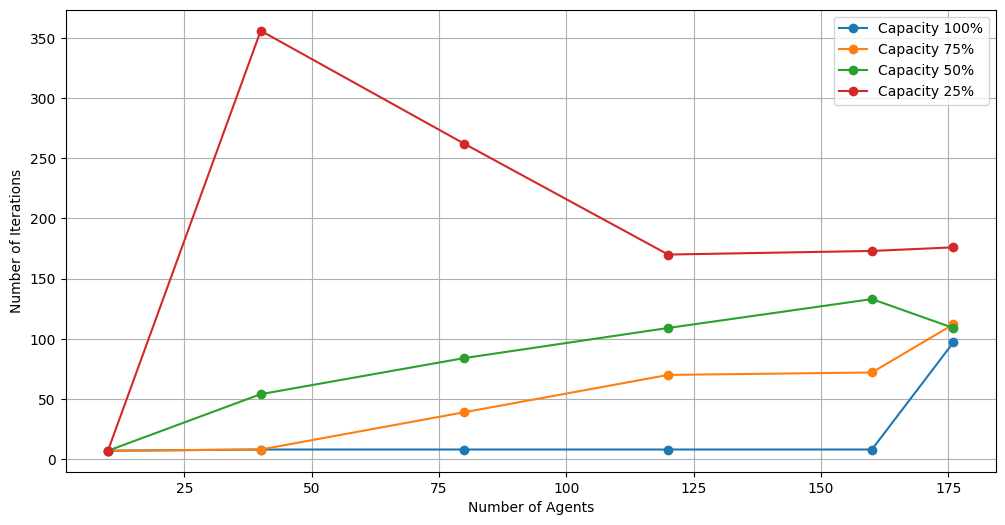

In [9]:
# Plotting the data
plt.figure(figsize=(12, 6))
# plt.title("Market Performance by Capacity")
plt.ylabel("Number of Iterations")
plt.xlabel("Number of Agents")
# plt.yticks(range(0, combined_df["Number_Interations"].max() + 10, 10))
plt.grid()
capacities = [100,75,50,25]
for capacity in combined_df["Capacity"].unique():
    if capacity == 13:
        cap = 100
    elif capacity == 10:
        cap = 75
    elif capacity == 7:
        cap = 50
    elif capacity == 4:
        cap = 25
    subset = combined_df[combined_df["Capacity"] == capacity]
    plt.plot(subset["Number_Agents"], subset["Number_Interations"], label=f"Capacity {cap}%", marker='o')

plt.legend()
current_dir = os.getcwd()
plt.savefig(f"{current_dir}/plots/nagents_niter.png")

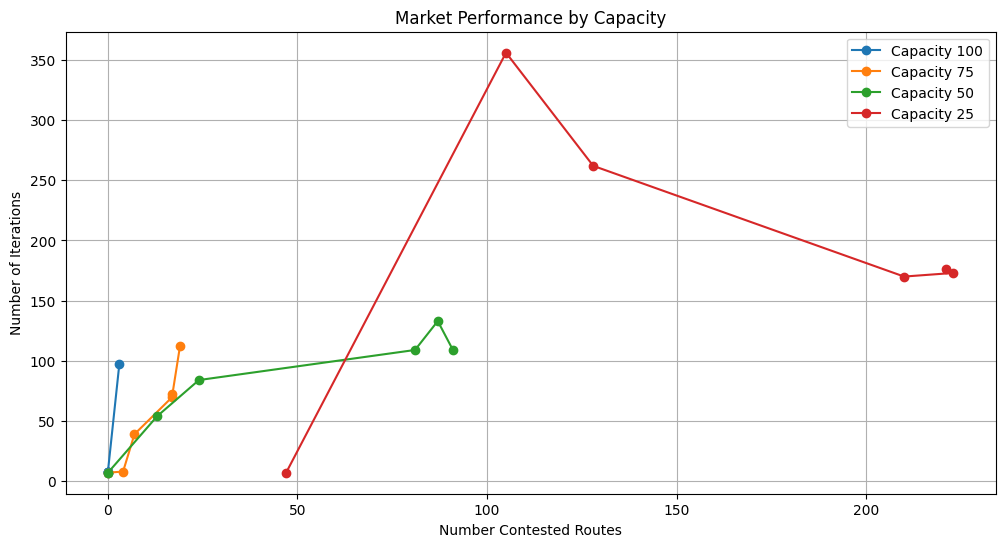

In [10]:
# Plotting the data
plt.figure(figsize=(12, 6))
plt.title("Market Performance by Capacity")
plt.ylabel("Number of Iterations")
plt.xlabel("Number Contested Routes")
plt.grid()
for capacity in combined_df["Capacity"].unique():
    if capacity == 13:
        cap = 100
    elif capacity == 10:
        cap = 75
    elif capacity == 7:
        cap = 50
    elif capacity == 4:
        cap = 25
    subset = combined_df[combined_df["Capacity"] == capacity]
    plt.plot(subset["Number_Contested_Routes"], subset["Number_Interations"], label=f"Capacity {cap}", marker='o')

plt.legend()



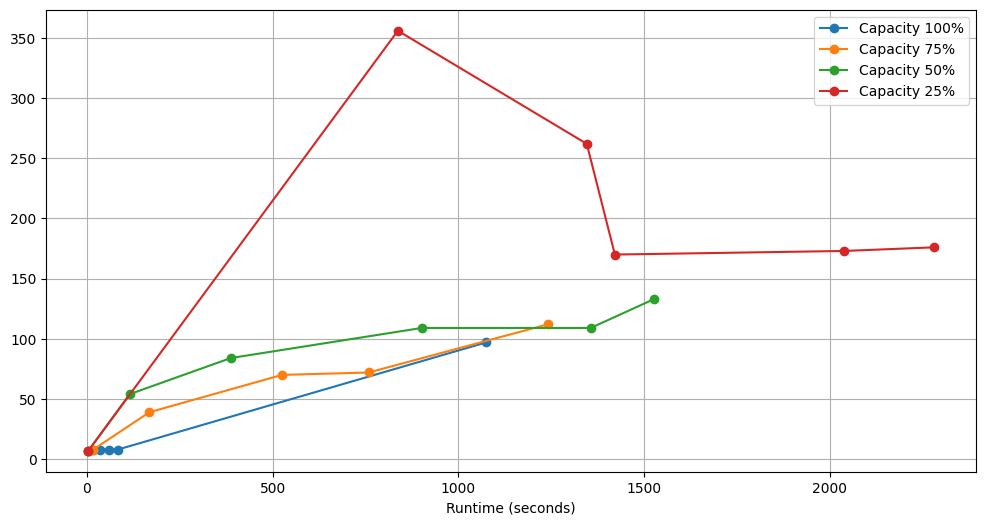

In [15]:
# Plotting the data
plt.figure(figsize=(12, 6))
# plt.title("Market Performance by Capacity")
# plt.ylabel("Number of Iterations")
plt.xlabel("Runtime (seconds)")
plt.grid()
for capacity in combined_df["Capacity"].unique():
    if capacity == 13:
        cap = 100
    elif capacity == 10:
        cap = 75
    elif capacity == 7:
        cap = 50
    elif capacity == 4:
        cap = 25
    subset = combined_df[combined_df["Capacity"] == capacity]
    subset = subset.sort_values(by="Run_Time")
    plt.plot(subset["Run_Time"], subset["Number_Interations"], label=f"Capacity {cap}%", marker='o')
    # plt.plot(subset["Number_Interations"], subset["Run_Time"], label=f"Capacity {cap}%", marker='o')
    # plt.plot(subset["Run_Time"], subset["Number_Interations"], label=f"Capacity {capacity}", marker='o')

plt.legend()
plt.savefig(f"{current_dir}/plots/runtime_niter.png")

Reading the files with Market Iterations: These are for multiple files and a fixed auction time

In [ ]:
current_dir = os.getcwd()
parent_folder = os.path.abspath(os.path.join(current_dir, ".."))

file_list = [
    "toulouse_case_cap4_updated_fisher_b-50.0_agents5_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250214_094310",
    "toulouse_case_cap4_updated_fisher_b-50.0_agents6_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250216_103847",
    "toulouse_case_cap4_updated_fisher_b-50.0_agents7_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250216_103947",
    "toulouse_case_cap4_updated_fisher_b-50.0_agents8_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250216_104044",
    "toulouse_case_cap4_updated_fisher_b-50.0_agents9_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250216_104230",
    "toulouse_case_cap4_updated_fisher_b-50.0_agents10_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250214_094549",
    "toulouse_case_cap4_updated_fisher_b-50.0_agents11_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250216_104712",
    "toulouse_case_cap4_updated_fisher_b-50.0_agents12_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250216_105524",
    "toulouse_case_cap4_updated_fisher_b-50.0_agents13_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250216_110417",
    "toulouse_case_cap4_updated_fisher_b-50.0_agents14_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250216_111839",
    "toulouse_case_cap4_updated_fisher_b-50.0_agents15_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250214_100800",
    "toulouse_case_cap4_updated_fisher_b-50.0_agents16_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250216_113033",
    "toulouse_case_cap4_updated_fisher_b-50.0_agents17_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250216_114352",
    "toulouse_case_cap4_updated_fisher_b-50.0_agents18_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250216_115829",
    "toulouse_case_cap4_updated_fisher_b-50.0_agents19_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250216_121327",
    "toulouse_case_cap4_updated_fisher_b-50.0_agents20_dval40.0_outval1.0_pout1.0_freq30.0_pbound3000.0_receding_20250216_122848",
]


df_list = []

for file in file_list:
    folder_path = os.path.join(parent_folder, "results", file, "results")
    csv_file_path = os.path.join(folder_path, 'market_performance_table.csv')
    
    try:
        df_csv = pd.read_csv(csv_file_path)
        df_csv["File"] = file  # column to track file origin
        n_agents = int(file.split('_agents')[1].split('_')[0])
        df_list.append(df_csv)
    except FileNotFoundError:
        print(f"File not found: {csv_file_path}")
    except pd.errors.EmptyDataError:
        print(f"File is empty: {csv_file_path}")

# Concatenate all DataFrames
pd.set_option('display.max_rows', None) 
if df_list:
    combined_df = pd.concat(df_list, ignore_index=True)
    # display(combined_df.head())
    display(combined_df)
else:
    print("No data was loaded.")

In [ ]:
filtered_df = combined_df[combined_df["Market_Auction_Start_Time"] == 60]

# Plotting
plt.figure(figsize=(8, 6))
plt.title("Number of Iterations vs. Number of Agents for Market Auction Time 60")
plt.xlabel("Number of Agents")
plt.ylabel("Number of Iterations")
plt.grid(True)

plt.scatter(filtered_df["Number_Agents"], filtered_df["Number_Interations"], marker='o')

# plt.legend()
plt.show()

In [ ]:
num_iter_row = combined_df[combined_df["Market_Auction_Start_Time"] == 60]
# this is because we save the number of contested goods after the market runs
num_consted_good_row = combined_df[combined_df["Market_Auction_Start_Time"] == 40]
# Plotting
plt.figure(figsize=(8, 6))
# plt.title("Number of Iterations vs. Number of Agents for Market Auction Time 60")
plt.xlabel("Number of Contested")
plt.ylabel("Number of Iterations")
plt.grid(True)

plt.scatter(num_consted_good_row["Number_Contested_Routes"], num_iter_row["Number_Interations"], marker='o')

# plt.legend()
plt.show()